# Create the Gym class

In this notebook I am going to create a class __"MtpoNes()"__ that will make it easier for me to execute all the necessary preprocessing during the project. This class makes it easy to modify the behavior of the __"Env"__ object of the retro gym library, and will have image preprocessing elements commented out in the previous notebook.

In [7]:
# Imports
# For gym functionality
from gym import Env
from gym.spaces import Discrete, Box
from retro import RetroEnv

import numpy as np
# Import opencv for grayscaling
import cv2
# Import matplotlib for plotting the image
from matplotlib import pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.monitor import Monitor

In [14]:
class RetroMtpoNesReduced(Env):
    """
    Class that creates a retro "Gym" object, and allows me to manipulate its observation space.
     With this I seek to reduce the observations space, to speed up the training stage.

     This class creates a "focus area", removing the outter most two thirds of the screen (vertically), 
     leaving in "focus" a area where the action of the game takes place. Additionally I reduce the number
     of color channels, from three to one, which gives the feeling that the game is in black and white (also
     called "grayscaling").

     In this class, additionally, the "viewing" area is reduced, going from an observation space of 196x80x1
     to one of 84x84x1.
     
     The main inspiration for this class comes from a Youtube tutorial from Nickolas Renotte.
     
     https://www.youtube.com/watch?v=rzbFhu6So5U&t=6248s
     
    """
    def __init__(self, state='GlassJoe.state',
                 scenario='scenario_king_hippo',
                 inttype=retro.data.Integrations.STABLE,
                 use_restricted_actions=retro.Actions.DISCRETE,
                 points_as_rewards=True):
        super(RetroEnv).__init__()
        # Most of these lines comes from GYM RETRO library.
        self.img = None
        rom_path = retro.data.get_romfile_path('Mtpo-Nes', inttype)
        self.system = retro.get_romfile_system(rom_path)
        core = retro.get_system_info(self.system)
        self.buttons = core['buttons']
        self.observation_space = Box(low=0, high=255, shape=(84,84,1), dtype=np.uint8)
        self.action_space = Discrete(24)
        self.state = state
        self.scenario = scenario
        self.use_restricted_actions = use_restricted_actions
        self.game = retro.make(game='Mtpo-Nes',
                               state=self.state,
                               scenario=self.scenario,
                               use_restricted_actions=self.use_restricted_actions)
        self.points_as_rewards = points_as_rewards
        self.picture = None
        

    def preprocess(self, observation):
        """ 
        Method to preprocess the images that the "RetroEnv" object uses during training.
         The idea is to deliver a reduced observation, which helps streamline the training processes of the
         agent. The derivation of the reduced observation can be seen in the notebook:
        
         - '1_CV_Preprocessing.ipynb'
        
         which is part of this 'Notebooks' section
        """
        # Cropping
        xlen = observation.shape[0]
        ylen = observation.shape[1]
        focus_zone = observation[int(xlen*(1/8)):int(xlen*(3/2)),int(ylen/3):-int(ylen/3)]
        # Grayscale
        gray = cv2.cvtColor(focus_zone, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        
        # We must fit the output to a tensor with three dimensions, since
        # it is the data structure that the gym object expects.
        # values between 0 and 1.
        channels = np.reshape(resize, (84,84,1))

        return channels

    def reset(self):
        # Returns the fist "frame"
        obs = self.game.reset()
        processed_obs = self.preprocess(obs)
        self.score = 0
        self.picture = processed_obs
        return processed_obs
    
    def step(self, action):
        # Go one step further in the emulation of the game
        # Integrate the modification to the observation using the "preprocessed()" method
        obs, reward, done, info = self.game.step(action)
        processed_obs = self.preprocess(obs)
        
        # This is to return the points of the game as the reward if we want it.
        if self.points_as_rewards:
            reward_as_points = info['POINTS'] - self.score
            self.score = info['POINTS']
            return processed_obs, reward_as_points, done, info
        else:  
            return processed_obs, reward, done, info
    
    # The rest of the methods are not used much, yet might come in
    # handy in some cases
    def render(self, *args, **kwargs):
        self.game.render()
        
    def close(self):
        self.game.close()

    def get_image(self):
        return self.picture
    
    def get_buttons(self):
        return self.buttons
    
    def get_action_meaning(self, act):
        return self.game.get_action_meaning(act)
    
    def get_in_game_score(self):
        return self.score

    def get_in_game_reward(self):
        return self.in_game_reward

Let´s instantiate the class to check if it is working:

In [15]:
env = RetroMtpoNesReduced()
env.observation_space.shape

(84, 84, 1)

Above we can see that the shape of the image is as expected.

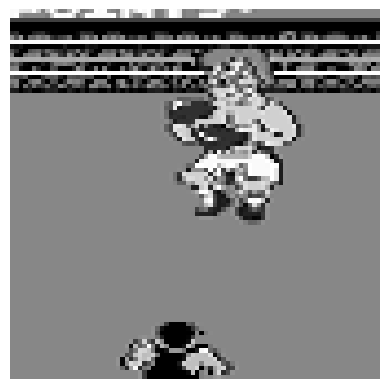

In [16]:
init_obs = env.reset()
accion = env.action_space.sample()
obs, reward, done, info = env.step(accion)
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

We see that the __"RetroMtpoNesReduced()"__ class does all the requested pre-processing, and it works without any problems.